In [1]:
import os
import pandas as pd
import rasterio
import geopandas as gpd
import numpy as np
from rasterstats import zonal_stats
from shapely.geometry import Point, box
from shapely.wkt import loads
from shapely.geometry import Point
import shapely as sp
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [4]:
basepath = "../data/raw_suitability_data/"

GHI= "GHI-09188ce2.tif"
protected_land = "Protected_Land-5745a356.tif"
habitat= "Habitat-32079c87.tif"
slope= "slope_only-2c1658fa.tif"
popl_dens= "Popl_Density-714f0a64.tif"
Substation = "distance_to_substation_only-f02c9129.tif"
land_cover="Land_Cover-8a2691e6.tif"
# Define the TIF file paths as a list
tif_paths = [GHI, protected_land, habitat, slope, popl_dens, Substation, land_cover]
tif_paths_full = [basepath + path for path in tif_paths]
tif_paths_full

['../data/raw_suitability_data/GHI-09188ce2.tif',
 '../data/raw_suitability_data/Protected_Land-5745a356.tif',
 '../data/raw_suitability_data/Habitat-32079c87.tif',
 '../data/raw_suitability_data/slope_only-2c1658fa.tif',
 '../data/raw_suitability_data/Popl_Density-714f0a64.tif',
 '../data/raw_suitability_data/distance_to_substation_only-f02c9129.tif',
 '../data/raw_suitability_data/Land_Cover-8a2691e6.tif']

In [5]:
# Load in Solar Data
solar_data = pd.read_csv("../data/projects/solar/solar_raw.csv")
# rename wkt column to geometry
solar_data.rename(columns={"WKT": "geometry"}, inplace=True)
print("The shape of the solar data is: ", solar_data.shape)
solar_data.head()

The shape of the solar data is:  (4180, 22)


,plant_code,plant_name,utility_na,utility_id,sector_nam,city,county,statename,zip,street_add,primsource,install_mw,total_mw,solar_mw,source_des,tech_desc,source,period,latitude,longitude,geometry,Unnamed: 21
0,10029,General Electric Aircraft Engines,General Electric Aircraft Engines,7049,Industrial Non-CHP,Lynn,Essex,Massachusetts,1910,1000 Western Avenue,solar,2.1,2.1,2.1,Solar = 2.1 MW,Solar Photovoltaic,"EIA-860, EIA-860M and EIA-923",202108,42.450000,-70.973900,POINT Z (-70.9739 42.450000000000074 0),Massachusetts
1,10437,Sunray 2,"Sunray Energy 2, LLC",60246,IPP Non-CHP,Daggett,San Bernardino,California,92327,35100 Santa Fe Street,solar,20.0,20.0,20.0,Solar = 20 MW,Solar Photovoltaic,"EIA-860, EIA-860M and EIA-923",202108,34.863356,-116.827627,POINT Z (-116.82762700000005 34.86335600000007...,California
2,10438,Sunray 3,Sunray Energy 3 LLC,60247,IPP Non-CHP,Daggett,San Bernardino,California,92327,35100 Santa Fe St,solar,13.8,13.8,13.8,Solar = 13.8 MW,Solar Photovoltaic,"EIA-860, EIA-860M and EIA-923",202108,34.863356,-116.827627,POINT Z (-116.82762700000005 34.86335600000007...,Arizona
3,10444,SEGS VIII,Terra-Gen Operating Co-Solar,61950,IPP Non-CHP,Hinkley,San Bernardino,California,92347,43880 Harper Lake Road,solar,92.0,80.0,80.0,Solar = 80 MW,Solar Thermal without Energy Storage,"EIA-860, EIA-860M and EIA-923",202108,35.030800,-117.356300,POINT Z (-117.35630000000009 35.03080000000018 0),Nevada
4,10446,SEGS IX,Terra-Gen Operating Co-Solar,61950,IPP Non-CHP,Hinkley,San Bernardino,California,92347,43880 Harper Lake Road,solar,92.0,88.0,88.0,Solar = 88 MW,Solar Thermal without Energy Storage,"EIA-860, EIA-860M and EIA-923",202108,35.033000,-117.338000,POINT Z (-117.33800000000005 35.0330000000001 0),Colorado


# Using the geometry find the suitability of the point where the project is located

**Note**:
- Some projects are at points with NaN values
    - To handle we find the closest point with a value and use that value
    - **NEW** Get a metric of how close the closest point is to the project point 
- Values clipped to 0 - 100 to remove 255 values which are no-data values

In [6]:
from scipy.ndimage import distance_transform_edt
col_names = ["GHI", "Protected_Land", "Habitat", "Slope", "Population_Density", "Distance_to_Substation", "Land_Cover"]

def get_average_value(array, row, col, window_size=3, nodata_value=255):
    """
    Calculate the average value of pixels in a square window around a specified row and column,
    ignoring nodata values.

    Args:
        array: 2D NumPy array of raster data.
        row: Row index of the point in the raster.
        col: Column index of the point in the raster.
        window_size: Half the size of the square window (e.g., 3 means a 7x7 window).
        nodata_value: Value representing nodata in the raster.

    Returns:
        Average value of the valid pixels in the window. If all pixels are nodata, return None.
    """
    # Define the window boundaries
    row_min = max(0, row - window_size)
    row_max = min(array.shape[0], row + window_size + 1)
    col_min = max(0, col - window_size)
    col_max = min(array.shape[1], col + window_size + 1)

    # Extract the window
    window = array[row_min:row_max, col_min:col_max]

    # Mask out nodata values
    valid_values = window[window != nodata_value]

    # If no valid values are present, return None
    if valid_values.size == 0:
        return None

    # Calculate and return the mean of valid values
    return valid_values.mean()


def get_closest_edge_value(array, row, col, nodata_value=255):
    """
    Finds the closest raster value for a point outside the raster bounds.

    Args:
        array: 2D NumPy array of raster data.
        row: Row index of the point in the raster.
        col: Column index of the point in the raster.
        nodata_value: Value representing nodata in the raster.

    Returns:
        Cloest valid value indices
    """
    # Clamp the row and col to raster bounds
    row = min(max(0, row), array.shape[0] - 1)
    col = min(max(0, col), array.shape[1] - 1)

    # If the value is nodata, find the nearest valid value
    if array[row, col] == nodata_value:
        valid_mask = array != nodata_value
        distances, indices = distance_transform_edt(valid_mask, return_indices=True)
        closest_index = indices[:, row, col]
        print(closest_index)
        return array[tuple(closest_index)], distances[row, col]

    return array[row, col], 0


def calculate_point_values_with_average(tif_path, geodataframe, window_size=3, nodata_value=255):
    """
    Extracts the average raster values around point locations using a square window,
    handling out-of-bounds cases.
    """
    with rasterio.open(tif_path) as src:
        affine = src.transform
        raster_crs = src.crs
        array = src.read(1)
        height, width = array.shape

        print(raster_crs)
        # Ensure CRS alignment
        geodataframe = geodataframe.to_crs(raster_crs)
        # array = np.where(np.isnan(array), nodata_value, array)
        

        values = []
        distances = []
        count = 0
        for i, geom in enumerate(geodataframe.geometry):
            if geom.has_z:
                geom = Point(geom.x, geom.y)

            # Map point to raster indices
            col, row = ~affine * (geom.x, geom.y)
            row, col = int(row), int(col)

            # Check if indices are within bounds
            if 0 <= row < height and 0 <= col < width:
                # Get the average value around the point
                value = get_average_value(array, row, col, window_size, nodata_value)
            else:
                # Return nodata_value if out of bounds
                value = np.nan
                print(f"Point {i} is out of bounds")
                
            values.append(value)
            # Debugging output
            if i % 100 == 0:
                print(f"Processed {i}/{len(geodataframe.geometry)} points")
        return values, distances


def process_tif_files_with_average(tif_filepaths, geodataframe, window_size=50, nodata_value=255, get_distance=False):
    """
    Process multiple TIFF files and extract average values around point locations using a square window,
    handling out-of-bounds cases.
    """
    # Convert WKT Point Z strings to geometries if necessary
    if isinstance(geodataframe.geometry.iloc[0], str):
        geodataframe["geometry"] = geodataframe["geometry"].apply(loads)
    geodataframe = gpd.GeoDataFrame(geodataframe, geometry="geometry", crs="EPSG:4326")  # Adjust CRS as needed

    # Initialize results DataFrame
    results = pd.DataFrame(index=geodataframe.index, columns=col_names)

    for tif_path, col_name in zip(tif_filepaths, col_names):
        print(f"Processing {tif_path} for {col_name}")

        # Extract average values from the raster around point locations
        values, distances = calculate_point_values_with_average(tif_path, geodataframe, window_size, nodata_value)

        # Update results DataFrame
        results[col_name] = values
        if get_distance:
            results[f"{col_name}_distance"] = distances

    # Add geometry back to the results DataFrame
    results["geometry"] = geodataframe["geometry"]
    # Add the wattage column back to the results DataFrame
    results["Wattage"] = geodataframe["total_mw"]

    return results


In [7]:
# get the suitablility data
suitability_data = process_tif_files_with_average(tif_paths_full, solar_data, nodata_value=255)

Processing ../data/raw_suitability_data/GHI-09188ce2.tif for GHI
EPSG:3857
Processed 0/4180 points
Point 9 is out of bounds
Processed 100/4180 points
Point 162 is out of bounds
Processed 200/4180 points
Processed 300/4180 points
Point 395 is out of bounds
Processed 400/4180 points
Point 407 is out of bounds
Processed 500/4180 points
Point 561 is out of bounds
Processed 600/4180 points
Point 608 is out of bounds
Point 609 is out of bounds
Point 617 is out of bounds
Point 620 is out of bounds
Point 621 is out of bounds
Point 622 is out of bounds
Point 624 is out of bounds
Point 633 is out of bounds
Point 636 is out of bounds
Processed 700/4180 points
Processed 800/4180 points
Processed 900/4180 points
Processed 1000/4180 points
Processed 1100/4180 points
Processed 1200/4180 points
Processed 1300/4180 points
Point 1396 is out of bounds
Processed 1400/4180 points
Point 1472 is out of bounds
Processed 1500/4180 points
Processed 1600/4180 points
Processed 1700/4180 points
Point 1730 is out o

## Extract the county and state and GEOID from the project point

In [61]:
# Load Block Group Data
block_group_bb = gpd.read_file("") # file too large to upload
block_group_bb.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOIDFQ,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER,geometry
0,01,113,030300,1,1500000US011130303001,011130303001,1,Block Group 1,BG,829037,0,"POLYGON ((-85.00366 32.47885, -85.00133 32.480..."
1,04,015,953406,2,1500000US040159534062,040159534062,2,Block Group 2,BG,577144904,15330641,"POLYGON ((-114.32649 34.43788, -114.31824 34.4..."
2,04,001,945002,1,1500000US040019450021,040019450021,1,Block Group 1,BG,607817889,362533,"POLYGON ((-109.32335 35.54182, -109.31495 35.5..."
3,04,027,000301,2,1500000US040270003012,040270003012,2,Block Group 2,BG,2041298,71837,"POLYGON ((-114.66727 32.72505, -114.66541 32.7..."
4,05,007,020803,3,1500000US050070208033,050070208033,3,Block Group 3,BG,3545865,53379,"POLYGON ((-94.27908 36.48882, -94.27656 36.491..."


In [62]:
# Function to get the GEOID from a point
def get_GEOID_from_point(z, block_group_bb):
    intersect = block_group_bb[block_group_bb.intersects(z)]
    # Handle cases with no or multiple intersections
    if len(intersect) == 0:
        print(f"No intersection found for point: {z}")
        return (None, None, None, None, None)
    elif len(intersect) > 1:
        print(f"More than one intersection found for point: {z}")
        return (None, None, None, None, None)
    
    # Return the relevant details from the intersection
    x= (intersect.iloc[0]['GEOID'], 
            intersect.iloc[0]['STATEFP'], 
            intersect.iloc[0]['COUNTYFP'], 
            intersect.iloc[0]['TRACTCE'], 
            intersect.iloc[0]['BLKGRPCE'],
    )
    return x

In [63]:
suitability_data[['GEOID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE']] = suitability_data['geometry'].apply(lambda x: get_GEOID_from_point(x, block_group_bb)).apply(pd.Series)

In [64]:
# Verify the results
print(f"Number of NaNs:\n{suitability_data.isna().sum()}\n") # verify nans

# verfiy all suitablility data has is between 0 and 100
for col in col_names:
    print(f"{col} min: {suitability_data[col].min()}, max: {suitability_data[col].max()}")
    
# Count the number of rows with NaN values
print(f"Number of rows with NaN values: {suitability_data.isna().any(axis=1).sum()}")
    
# Remove rows with NaN values as they are out of the raster bounds for some reason (Guess Corrupt data)
suitability_data = suitability_data.dropna()


Number of NaNs:
GHI                       40
Protected_Land            40
Habitat                   40
Slope                     40
Population_Density        40
Distance_to_Substation    40
Land_Cover                40
geometry                   0
Wattage                    0
GEOID                      0
STATEFP                    0
COUNTYFP                   0
TRACTCE                    0
BLKGRPCE                   0
dtype: int64

GHI min: 5.0, max: 90.0
Protected_Land min: 26.8272718360945, max: 100.0
Habitat min: 5.0, max: 99.74904421135183
Slope min: 5.53396725811195, max: 100.0
Population_Density min: 10.0, max: 100.0
Distance_to_Substation min: 50.0, max: 92.56543476129791
Land_Cover min: 36.01181434599156, max: 99.73630036270954
Number of rows with NaN values: 40


In [66]:
# Save to CSV
suitability_data.to_csv("../../data/suitability_scores/suitability_scores_project.csv", index=False)

# Visualize Raster map to make sure the points make sense

- Creating a heatmap of the values to confirm the points to values are correct

In [11]:
tif_mapper = {
    "GHI": 0, "Protected_Land": 1, "Habitat": 2, "Slope": 3, "Population_Density": 4, "Distance_to_Substation": 5, "Land_Cover": 6
}
vis_var = "GHI"

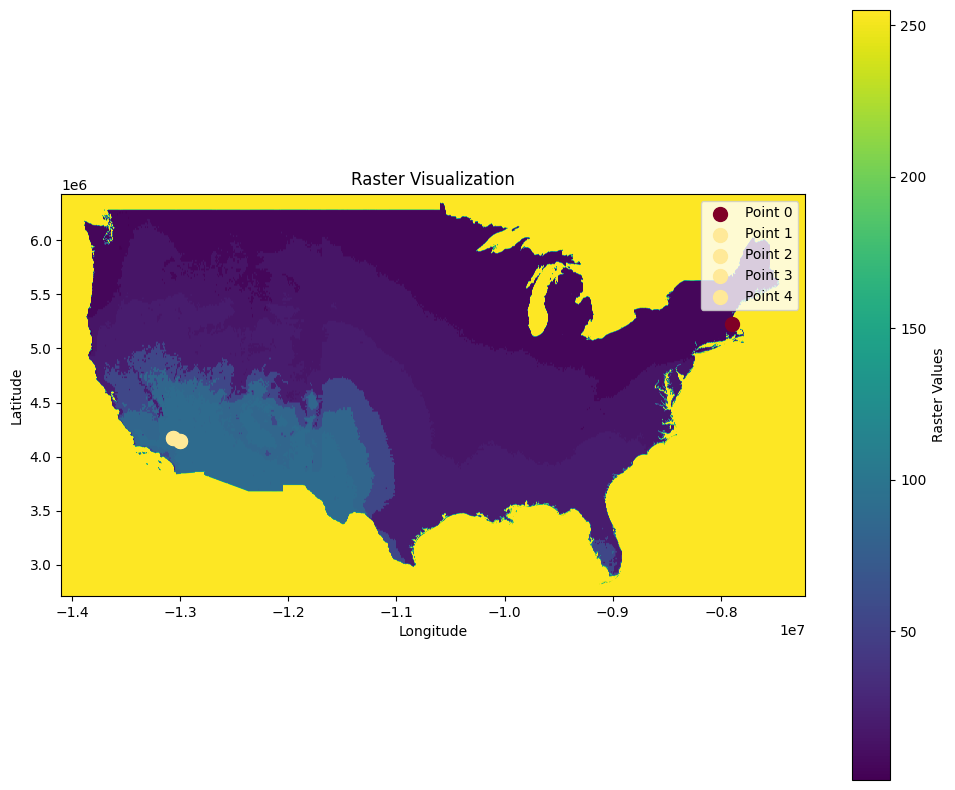

In [45]:
# Open the raster file
with rasterio.open(tif_paths_full[tif_mapper[vis_var]]) as src:
    array = src.read(1)  # Read the first band
    array = array.astype(float)  # Ensure it's a float array for NaN handling
    array[array == src.nodata] = float("nan")  # Replace nodata values with NaN
    transform = src.transform
    raster_crs = src.crs

# Plot the raster and the points
fig, ax = plt.subplots(figsize=(12, 10))

# Plot raster
plt.imshow(array, cmap='viridis', extent=(
    transform[2],  # left
    transform[2] + array.shape[1] * transform[0],  # right
    transform[5] + array.shape[0] * transform[4],  # top
    transform[5]  # bottom
), origin="upper")
plt.colorbar(label="Raster Values")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Raster Visualization")

# Plot the points
vis_data = gpd.GeoDataFrame(suitability_data.head(5)).copy().to_crs(raster_crs)


for i, row in vis_data.iterrows():
    score = row[vis_var]
    color = plt.cm.YlOrRd(score / 100)  # Normalize score to [0, 1] for colormap
    ax.scatter(row.geometry.x, row.geometry.y, color=color, s=100, label=f"Point {i}")
    
    
# Add legend
plt.legend()

plt.show()


# Map visualizing where all the points are relative to the raster map

In [ ]:
# Load in Solar Data
solar_data = pd.read_csv("data/solar_data.csv")
# rename wkt column to geometry
solar_data.rename(columns={"WKT": "geometry"}, inplace=True)
print("The shape of the solar data is: ", solar_data.shape)

solar_data["geometry"] = solar_data["geometry"].apply(loads)
solar_data = gpd.GeoDataFrame(solar_data, geometry="geometry", crs="EPSG:4326")

# Open the raster file
with rasterio.open(tif_paths_full[tif_mapper[vis_var]]) as src:
    array = src.read(1)  # Read the first band
    array = array.astype(float)  # Ensure it's a float array for NaN handling
    print(f"nodata value: {src.nodata}")
    array[array == src.nodata] = float("nan")  # Replace nodata values with NaN
    transform = src.transform
    raster_crs = src.crs

# Plot the raster and the points
fig, ax = plt.subplots(figsize=(12, 10))

# Plot raster
plt.imshow(array, cmap='viridis', extent=(
    transform[2],  # left
    transform[2] + array.shape[1] * transform[0],  # right
    transform[5] + array.shape[0] * transform[4],  # top
    transform[5]  # bottom
), origin="upper")
plt.colorbar(label="Raster Values")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Raster Visualization")

# Plot the points
vis_data = gpd.GeoDataFrame(solar_data).copy().to_crs(raster_crs)
print(vis_data.crs)
count = 0
array_bounds = [transform[2], transform[5], transform[2] + array.shape[1] * transform[0], transform[5] + array.shape[0] * transform[4]]
for i, row in vis_data.iterrows():
    # count the number of points not in the raster bounds
    if not sp.geometry.box(*array_bounds).contains(row.geometry):
        count += 1
        ax.scatter(row.geometry.x, row.geometry.y, color='red', s=100)
    ax.scatter(row.geometry.x, row.geometry.y, color='red', s=100)
    
    
# Add legend
# plt.legend()

plt.show()
